# Introduction

PySpark is an interface for Apache Spark in Python. It not only allows you to write Spark applications using Python APIs, but also provides the PySpark shell for interactively analyzing your data in a distributed environment.

This notebook covers the Machine Learning libraries of PySpark.

Process is simple.
1. For every dataset, we create 2 columns: Features and Label (Label not applicable to Clustering & Recommendation Model)
2. We form and train the model on training data
3. We evaluate the model
4. We test the model

# ML Content:
### 1. Regression
### 2. Classification
### 3. Clustering
### 4. Recommendation System
### 5. NLP

# Common Actions:
Below code will remain common for all ML processes

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# initiating Pyspark session
import findspark

findspark.init("/home/shounak/spark-3.1.2-bin-hadoop3.2")
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("demo").getOrCreate()
# We use pandas for
import pandas as pd
from sklearn.datasets import load_boston, load_iris
import time
import os

# Importing the methods that we will be using:
from pyspark.sql.functions import udf, countDistinct

# udf = User Defined Functions
# countDistinct = Counts the number of distinct values in a column

# Import Feature Processing Models
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler

# VectorAssembler = Forms feature column,
# StringIndexer = Converts String to Vector
# StandardScaler = Normalises the numeric features

# Import Evaluation Metrics
from pyspark.ml import evaluation
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

# Import Machine Learning Models
# Regression Model
from pyspark.ml.regression import LinearRegression

# Classification Model
from pyspark.ml.classification import (
    GBTClassifier,
    NaiveBayes,
    RandomForestClassifier,
    DecisionTreeClassifier,
    MultilayerPerceptronClassifier,
)

# Clustering Model
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt  # Used for determining ideal cluster numbers using elbow-method

# Recommendation Model
from pyspark.ml.recommendation import ALS

# For building NLP features and labels:
from pyspark.ml.feature import (
    RegexTokenizer,
    StopWordsRemover,
    HashingTF,
    IDF,
    StringIndexer,
)

# For building pipeline of methods:
from pyspark.ml import Pipeline

21/10/14 19:29:09 WARN Utils: Your hostname, shounak-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
21/10/14 19:29:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/14 19:29:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Create scaler function
scaler = StandardScaler(inputCol="raw_features", outputCol="features")

In [4]:
# Function to remove null and duplicate values
def rem_null_duplicates(dataframe):
    dataframe = dataframe.dropna()
    dataframe = dataframe.dropDuplicates()

In [5]:
def skdataset_to_sparkdataset(sklearn_dataset):
    load_sklearn_dataset = sklearn_dataset()
    pd_df = pd.DataFrame(
        data=load_sklearn_dataset["data"], columns=load_sklearn_dataset["feature_names"]
    )
    pd_df["target"] = load_sklearn_dataset["target"]
    #     pd_df.to_csv("temp_df.csv", index=False)
    #     spark_df = spark.read.csv("temp_df.csv",inferSchema=True, header=True)
    spark_df = spark.createDataFrame(pd_df)
    return spark_df

# 1. Regression

In [6]:
# Form dataset
regression_df = skdataset_to_sparkdataset(load_boston)
# Remove Null values & Duplicates
rem_null_duplicates(regression_df)
# Let us visualize dataset
regression_df.show(2)

+-------+----+-----+----+-----+-----+----+------+---+-----+-------+-----+-----+------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|  TAX|PTRATIO|    B|LSTAT|target|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+-----+-----+------+
|0.00632|18.0| 2.31| 0.0|0.538|6.575|65.2|  4.09|1.0|296.0|   15.3|396.9| 4.98|  24.0|
|0.02731| 0.0| 7.07| 0.0|0.469|6.421|78.9|4.9671|2.0|242.0|   17.8|396.9| 9.14|  21.6|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+-----+-----+------+
only showing top 2 rows



In [7]:
# We use VectorAssembler to form features-column consisting of array of features out of the available features
assembler_lin_reg = VectorAssembler(
    inputCols=[
        "CRIM",
        "ZN",
        "INDUS",
        "CHAS",
        "NOX",
        "RM",
        "AGE",
        "DIS",
        "RAD",
        "TAX",
        "PTRATIO",
        "B",
        "LSTAT",
    ],
    outputCol="raw_features",
)


regression_df = assembler_lin_reg.transform(regression_df)

# We will scale the features column
regression_df = scaler.fit(regression_df).transform(regression_df)
# Since we only want 2 columns "features" &"target" to train the model, we will not select other columns
regression_df = regression_df.select("features", "target")

# Visualize the cleaned dataset
regression_df.show(2)

21/10/14 19:29:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------+
|            features|target|
+--------------------+------+
|[7.34751712931429...|  24.0|
|[0.00317501096205...|  21.6|
+--------------------+------+
only showing top 2 rows



In [8]:
# Split dataset into train and test
train_regression_df, test_regression_df = regression_df.randomSplit([0.8, 0.2])

# form the model
linear_regression = LinearRegression(
    featuresCol="features",
    labelCol="target",
)
# train the model
lin_reg_model = linear_regression.fit(train_regression_df)
# Check the results on test data
test_result = lin_reg_model.transform(test_regression_df)
# Visualize the test data post transformation
test_result.show(3)

21/10/14 19:29:34 WARN Instrumentation: [efec6a7f] regParam is zero, which might cause numerical instability and overfitting.
21/10/14 19:29:34 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/14 19:29:34 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/14 19:29:34 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/10/14 19:29:34 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+--------------------+------+------------------+
|            features|target|        prediction|
+--------------------+------+------------------+
|[7.34751712931429...|  24.0|29.883776390779744|
|[0.00105329913277...|  32.2| 31.45741726581836|
|[0.00158111128099...|  18.9|15.988440265210585|
+--------------------+------+------------------+
only showing top 3 rows



In [9]:
# Initiate the evaluator
evaluator_lin_reg = RegressionEvaluator(predictionCol="prediction", labelCol="target")
# Check the RSME value
evaluation_lin_reg = evaluator_lin_reg.evaluate(test_result)
print("RSME for the Linear Regression model on test cases is ", evaluation_lin_reg)

RSME for the Linear Regression model on test cases is  5.1140560325727


# 2. Classification

In [10]:
# Form dataset
classification_df = skdataset_to_sparkdataset(load_iris)
# Remove Null values & Duplicates
rem_null_duplicates(classification_df)
# Let us visualize dataset
classification_df.show(2)

+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
+-----------------+----------------+-----------------+----------------+------+
only showing top 2 rows



In [11]:
# We use VectorAssembler to form features-column consisting of array of features out of the available features
assembler_classification = VectorAssembler(
    inputCols=[
        "sepal length (cm)",
        "sepal width (cm)",
        "petal length (cm)",
        "petal width (cm)",
    ],
    outputCol="raw_features",
)
classification_df = assembler_classification.transform(classification_df)

# We will scale the features column
classification_df = scaler.fit(classification_df).transform(classification_df)

# Since we only want 2 columns "features" &"target" to train the model, we will not select other columns
classification_df = classification_df.select("features", "target")

# Visualize the cleaned dataset
classification_df.show(2)

+--------------------+------+
|            features|target|
+--------------------+------+
|[6.15892840883878...|     0|
|[5.9174018045706,...|     0|
+--------------------+------+
only showing top 2 rows



In [12]:
# Split dataset into train and test
train_classification_df, test_classification_df = classification_df.randomSplit(
    [0.8, 0.2]
)

# GBTClassifier is limited to binary classification, so we will not use GBT in this case.

# Form the models:
# NaiveBayes model
nb = NaiveBayes(labelCol="target")
# Random Forest model
rf = RandomForestClassifier(labelCol="target")
# Decision Tree model
dc = DecisionTreeClassifier(labelCol="target")
# Multilayer Perceptron model
mp = MultilayerPerceptronClassifier(labelCol="target", layers=[4, 5, 4, 3])

In [13]:
# Train NaiveBayes model
nb_model = nb.fit(train_classification_df)
# Train Random Forest model
rf_model = rf.fit(train_classification_df)
# Train Decision Tree model
dc_model = dc.fit(train_classification_df)
# Train Multilayer Perceptron model
mp_model = mp.fit(train_classification_df)

In [14]:
# Check the results on test data:
# Transformed test data for NaiveBayes model
nb_test_result = nb_model.transform(test_classification_df)
# Transformed test data for Random Forest model
rf_test_result = rf_model.transform(test_classification_df)
# Transformed test data for Decision Tree model
dc_test_result = dc_model.transform(test_classification_df)
# Transformed test data for Multilayer Perceptron model
mp_test_result = mp_model.transform(test_classification_df)

In [15]:
# Initiate the evaluator
evaluator_classification = evaluation.MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol="target", metricName="accuracy"
)

In [16]:
# Check the model accuracy
print(
    "Naive-Bayes Classifier accuracy: ",
    evaluator_classification.evaluate(nb_test_result),
)
print()
print(
    "Random Forest Classifier accuracy: ",
    evaluator_classification.evaluate(rf_test_result),
)
print()
print(
    "Decision Tree Classifier accuracy: ",
    evaluator_classification.evaluate(dc_test_result),
)
print()
print(
    "Maltilayer Preceptron Classifier accuracy: ",
    evaluator_classification.evaluate(mp_test_result),
)

Naive-Bayes Classifier accuracy:  0.9166666666666666

Random Forest Classifier accuracy:  0.9583333333333334

Decision Tree Classifier accuracy:  0.9583333333333334

Maltilayer Preceptron Classifier accuracy:  0.9583333333333334


# 3. Clustering

In [17]:
# Form dataset
clustering_df = skdataset_to_sparkdataset(load_iris)
# Remove Null values & Duplicates
rem_null_duplicates(clustering_df)
# Let us visualize dataset
clustering_df.show(2)

+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
+-----------------+----------------+-----------------+----------------+------+
only showing top 2 rows



In [18]:
# We use VectorAssembler to form features-column consisting of array of features out of the available features
assembler_clustering = VectorAssembler(
    inputCols=[
        "sepal length (cm)",
        "sepal width (cm)",
        "petal length (cm)",
        "petal width (cm)",
    ],
    outputCol="raw_features",
)

clustering_df = assembler_clustering.transform(clustering_df)

# We will scale the features column
clustering_df = scaler.fit(clustering_df).transform(clustering_df)

# Since we only want 2 columns "features" &"target" to train the model, we will not select other columns
clustering_df = clustering_df.select("features", "target")

# Visualize the cleaned dataset
clustering_df.show(2)

+--------------------+------+
|            features|target|
+--------------------+------+
|[6.15892840883878...|     0|
|[5.9174018045706,...|     0|
+--------------------+------+
only showing top 2 rows



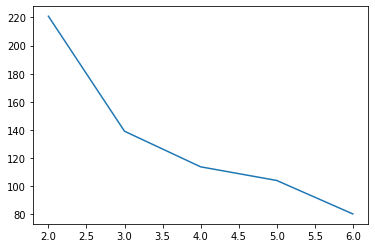

In [19]:
# To get the proper number of clusters, we use the elbow method

# Let us count the model-costs for clusters ranging from 2 to 6
model_cost_list = []
for i in range(2, 7):
    km = KMeans(k=i)
    km_model = km.fit(clustering_df)
    model_cost_list.append(km_model.summary.trainingCost)

# To get the elbow point, we will plot graph of model-costs against the cluster numbers
plt.plot(list(range(2, 7)), model_cost_list)

From above graph, it appears that elbow point is at "3". So we consider 3 optimal clusters

In [20]:
# Form KMeans model with number of clusters ("k") as 3
km = KMeans(k=3)

# Train KMeans model
km_model = km.fit(clustering_df)

# Transform the dataset so we can get the cluster predictions
clustering_result_df = km_model.transform(clustering_df)

In [21]:
# Let us check the number of points in 3 clusters as per MODEL PREDICTION
print("Cluster distribution as per MODEL PREDICTION: ")
print(clustering_result_df.groupBy("prediction").count().orderBy("prediction").show())
print()
print("---------------------------------------------------")
print()
# Let us check the ACTUAL number of points in 3 clusters
print("Cluster distribution as per MODEL PREDICTION: ")
print(clustering_df.groupBy("target").count().orderBy("target").show())

Cluster distribution as per MODEL PREDICTION: 


+----------+-----+
|prediction|count|
+----------+-----+
|         0|   44|
|         1|   50|
|         2|   56|
+----------+-----+

None

---------------------------------------------------

Cluster distribution as per MODEL PREDICTION: 


+------+-----+
|target|count|
+------+-----+
|     0|   50|
|     1|   50|
|     2|   50|
+------+-----+

None


From above, we see that KMeans has clustered the observations in 3 clusters. The count appears to be very close to the actual ones

# 4. Recommendation System

Currently in Pyspark, only Collaborative Filtering is supported.

In [31]:
# Dataset Location: https://www.kaggle.com/zygmunt/goodbooks-10k/version/5

# Form dataset
recommendation_df = spark.read.csv(
    "ratings.csv",
    inferSchema=True,
    header=True,
)

# Remove Null values & Duplicates
rem_null_duplicates(recommendation_df)

# Let us visualize dataset
recommendation_df.show(2)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
+-------+-------+------+
only showing top 2 rows



In [32]:
print("Length of recommendation_df is: ", recommendation_df.count())

Length of recommendation_df is:  981756


In [33]:
# Split dataset into train and test
train_recommendation_df, test_recommendation_df = recommendation_df.randomSplit(
    [0.8, 0.2]
)

In [34]:
# Form the ALS (Alternating Least Squares) model
als = ALS(
    userCol="user_id",
    itemCol="book_id",
    ratingCol="rating",
)

# Train the ALS (Alternating Least Squares) model
als_model = als.fit(train_recommendation_df)

# Transform the dataset using the model for evaluating the model
result_train_df = als_model.transform(train_recommendation_df)

# Let us evaluate the model
regression_evaluator = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="rating",
)
recommendation_evaluator = regression_evaluator.evaluate(result_train_df)
print(
    "RSME for the Recommendation System model on train cases is ",
    recommendation_evaluator,
)

RSME for the Recommendation System model on train cases is  0.5589353729879531


In [35]:
# Let us visualize the transformed dataset
test_recommendation_df.show(2)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|   1185|     4|
|      1|   2900|     5|
+-------+-------+------+
only showing top 2 rows



In [36]:
# Let us recommend products for 2 users as sample from test_recommendation_df
# Form list of 2 random users
recommendation_test_users = set()
i = 0
while len(recommendation_test_users) < 2:  # because we are testing on 2 sample users
    recommendation_test_users.add(
        test_recommendation_df.select("user_id").collect()[i][0]
    )
    i += 1
recommendation_test_users = list(recommendation_test_users)
print("The randomly selected 2 users are")
print()

# Let us recommend books for these 2 users
for user in recommendation_test_users:
    sample_case = test_recommendation_df[test_recommendation_df["user_id"] == user]
    result_sample_cases = als_model.transform(sample_case)
    print(f"Recommendation for user {user} is: ")
    result_sample_cases.show()
    print()

The randomly selected 2 users are

Recommendation for user 1185 is: 


+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|   3997|   1185|     4| 2.7417266|
|   2025|   1185|     4| 3.1450284|
|    271|   1185|     4|  3.408684|
|    209|   1185|     4| 3.2245934|
|   2013|   1185|     4|  2.765761|
|    346|   1185|     3| 3.3664932|
|    476|   1185|     4| 3.5940127|
|    696|   1185|     3| 3.0900347|
|   1488|   1185|     4| 3.3187504|
|      1|   1185|     4| 3.6717193|
|   7611|   1185|     2|    3.2576|
|     20|   1185|     3|  2.966312|
|   1988|   1185|     4| 3.3133562|
|    646|   1185|     3|  3.042126|
|   3027|   1185|     4| 3.2612684|
|    542|   1185|     3| 3.1015742|
|    579|   1185|     5| 3.2782383|
|   1299|   1185|     4| 3.5613766|
|    425|   1185|     3| 3.3331738|
|   1253|   1185|     3| 3.5067732|
+-------+-------+------+----------+
only showing top 20 rows


Recommendation for user 2900 is: 


+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    540|   2900|     5|  4.262825|
|     31|   2900|     4|  4.260079|
|    883|   2900|     5|  4.169362|
|    255|   2900|     5| 3.8190618|
|    122|   2900|     2| 3.6927922|
|      1|   2900|     5| 4.7931085|
|    297|   2900|     4|  4.143396|
|   3791|   2900|     3|  4.644528|
|    545|   2900|     3|  4.070191|
|     48|   2900|     5|  4.197024|
|    544|   2900|     5|  4.182472|
|    780|   2900|     5| 4.7492127|
|   6299|   2900|     3| 3.2514398|
|   5751|   2900|     5| 3.1552432|
|    117|   2900|     5| 4.4186234|
|    456|   2900|     5|  4.152709|
|    733|   2900|     4|  3.898293|
|   2561|   2900|     3|  4.093988|
|   8446|   2900|     3| 3.5869734|
|    494|   2900|     5| 3.9321508|
+-------+-------+------+----------+
only showing top 20 rows




# 5. Natural Language Processing

#### For Natural Language Processing, we will be using dataset of SMS texts which are classified into spam or ham.
We will train the model to classify the text. <br> 
#### Process:
1. Tokenize the SMS in words - use pyspark.ml.feature.RegexTokenizer()
2. Remove Stop-Words (words that do not add value to the sentence) - use pyspark.ml.feature.StopWordsRemover()
3. Use TF-IDF (term frequency–inverse document frequency) to convert words into vectors. These vectors will be the features for our model training - use pyspark.ml.feature.HashingTF & pyspark.ml.feature.IDF
4. Convert the word-label (spam/ham) into vectors (0/1) i.e. spam as 0 & ham as 1 - use pyspark.ml.feature.StringIndexer()
5. Train the model with features and labels - use Naive-Bayes Classifier
6. Evaluate the model
7. Predict sample cases

In [37]:
# Loading the data
nlp_data = spark.read.csv("SMSSpamCollection", inferSchema=True, sep="\t")

# Let us check how the dataset looks
nlp_data.show(5)

+----+--------------------+
| _c0|                 _c1|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
+----+--------------------+
only showing top 5 rows



In [38]:
# Let us rename the columns for convenience
nlp_data = nlp_data.withColumnRenamed("_c0", "text_label")
nlp_data = nlp_data.withColumnRenamed("_c1", "text")

In [39]:
# Let us build a pipeline which tokenizes the text and converts it into word-vector features
regex_state = RegexTokenizer(inputCol="text", outputCol="tokenized_text")
stopword_removed_state = StopWordsRemover(
    inputCol="tokenized_text", outputCol="text_wo_stopwords"
)
hashTF_state = HashingTF(inputCol="text_wo_stopwords", outputCol="hashed_tf")
idf_state = IDF(inputCol="hashed_tf", outputCol="features")

pipeline_route = Pipeline(
    stages=[
        regex_state,
        stopword_removed_state,
        hashTF_state,
        idf_state,
    ]
)


# Let us convert spam/ham to vectors 0/1
string_labelling = StringIndexer(inputCol="text_label", outputCol="label")

In [40]:
# Using pipeline to transform the dataframe
nlp_data = pipeline_route.fit(nlp_data).transform(nlp_data)
nlp_data = string_labelling.fit(nlp_data).transform(nlp_data)

In [41]:
# We need only 2 columns "features" and "label" to train our model. So we can ignore the remaining columns.
nlp_data = nlp_data.select(["features", "label"])

# Split dataset into train and test
train_nlp_data, test_nlp_data = nlp_data.randomSplit([0.8, 0.2])

In [42]:
# initiate Naive-Bayes classifier model
nbc = NaiveBayes(featuresCol="features", labelCol="label")

# Train the model using training dataset
nbc_model = nbc.fit(train_nlp_data)

21/10/14 19:35:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/14 19:35:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [43]:
# Test performance of the model on test dataset
test_nlp_data_result = nbc_model.transform(test_nlp_data)
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol="label", metricName="accuracy"
)
test_eval_score = evaluator.evaluate(test_nlp_data_result)
print("Test accuracy: ", test_eval_score)

21/10/14 19:35:59 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


Test accuracy:  0.9593345656192237


In [47]:
# Let us check the model on new SMS.
def show_category(text: str) -> str:
    """
    Returns if the entered text is Spam or Ham
    Args:
        text(str) - SMS text
    Returns:
        str : Whether the text is Spam or Ham
    """
    sample_df = spark.createDataFrame([{"text": text}])
    sample_df = pipeline_route.fit(sample_df).transform(sample_df)
    predicted_score = (
        nbc_model.transform(sample_df)
        .select(["text", "prediction"])
        .collect()[0]["prediction"]
    )
    if predicted_score == 0:
        return "spam"
    else:
        return "ham"

#### Demo cases:
For demonstration, we will pass random text samples from our dataframe without the label and see the prediction

In [48]:
# Spam
spam_text_1 = "England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/ú1.20 POBOXox36504W45WQ 16+"
spam_text_2 = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
# Ham
ham_text_1 = "I HAVE A DATE ON SUNDAY WITH WILL!!"
ham_text_2 = "Are you this much buzy"

In [49]:
print("Model prediction for spam_text_1 is ", show_category(spam_text_1))
print("Model prediction for spam_text_2 is ", show_category(spam_text_2))
print("Model prediction for ham_text_1 is ", show_category(ham_text_1))
print("Model prediction for ham_text_2 is ", show_category(ham_text_2))

21/10/14 19:37:02 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


Model prediction for spam_text_1 is  spam


21/10/14 19:37:03 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


Model prediction for spam_text_2 is  spam


21/10/14 19:37:04 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


Model prediction for ham_text_1 is  spam
Model prediction for ham_text_2 is  spam


21/10/14 19:37:05 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


## Thank you for viewing my Notebook<br>
## If you like the content or if you would like to collaborate on any project, please mail me on shounak.python@gmail.com<br>
## Any criticism or suggestions for improvement are welcome !<br>
## It is always encouraging to hear<br>